In [1]:
# Deep Learning with Python Ch3: Reuters example
# import necessary libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import reuters
from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
# load data: only keep top 10,000 most used words
# save np.load
np_load_old = np.load

# modify the default parameters of np.load: set allow_pickle to true
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [3]:
# see the 1st training newswire
word_index         = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire   = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])
print(decoded_newswire)
print(train_labels[0])

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
3


In [4]:
# vectorize newswires
def vectorize_sequences(sequences, dimension=10000):
    # row = # of data points, col = # of most used words
    results = np.zeros((len(sequences), dimension))
    # set value to 1 if the sequence-th word in the ith data pt is used
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 
    return results

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

# vectorize labels
def vectorize_labels(labels, dimension=46):
    # row = # of data points, col = # of categories
    results = np.zeros((len(labels), dimension))
    # set the label-th label to 1 for the ith data pt
    for i, label in enumerate(labels):
        results[i, label] = 1 
    return results

y_train = vectorize_labels(train_labels)
y_test  = vectorize_labels(test_labels)

In [8]:
# build and compile network
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [9]:
# validation approach
# set aside 1,000 samples from training data
x_val  = x_train[:1000]
x_part = x_train[1000:]
y_val  = y_train[:1000]
y_part = y_train[1000:]

# train network
history = model.fit(x_part, y_part, epochs=20, batch_size=512, 
                    validation_data=(x_val,y_val), verbose=0)

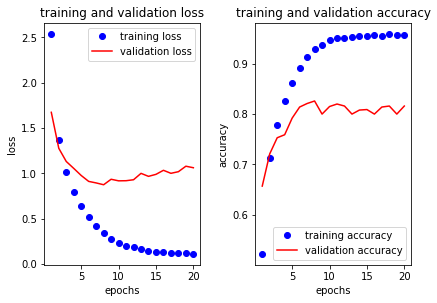

In [10]:
# plot losses and accuracies
history_dict = history.history
loss         = history_dict['loss']
val_loss     = history_dict['val_loss']
acc          = history_dict['acc']
val_acc      = history_dict['val_acc']
epochs       = range(1, len(loss)+1)

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.title('training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

In [11]:
# retrain network with # of epochs where min val_loss is located
# start fresh
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# retrain
best_epochs = np.argmin(val_loss)+1
model.fit(x_train, y_train, epochs=best_epochs, batch_size=512, verbose=0)
results = model.evaluate(x_test, y_test)
print(results)

2246/2246 [==============================] - 0s 188us/step
[0.9458456039428711, 0.7938557435971546]


In [18]:
# check the prediction on 1st test newswire
prediction = model.predict(x_test)
print('sum of probabilities:', np.sum(prediction[0]))
print('predicted category:', np.argmax(prediction[0]))
print('actual category:', np.where(y_test[0] == 1)[0][0]+1)

sum of probabilities: 1.0
predicted category: 3
actual category: 4


In [21]:
# compare to a random baseline
import copy
test_labels_copy = copy.copy(test_labels)

np.random.seed(1234)
np.random.shuffle(test_labels_copy)

hist_array = np.array(test_labels) == np.array(test_labels_copy)

base_acc = float(np.sum(hist_array))/len(test_labels)
print('random baseline accuracy: %.6f' %base_acc)

random baseline accuracy: 0.179875
